In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")
categ.drop(columns=["actor"], inplace=True)

from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import silhouette_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.pipeline import make_pipeline

In [31]:
from sklearn.metrics import adjusted_mutual_info_score as ami, silhouette_score

def meanAMI(labels, dataframe):
    mAMI= 0 
    
    for feat in dataframe.columns:
        featAMI = ami(labels, dataframe[feat])
        mAMI += featAMI/len(dataframe.columns)
    return mAMI

def get_maxAMI_feature(labels, dataframe):
    MAMI = 0
    MAMIfeat = dataframe.columns[0]
    for feat in dataframe.columns:
        featAMI = ami(labels, dataframe[feat])
        MAMIfeat = feat if featAMI > MAMI else MAMIfeat
        MAMI = max(MAMI, featAMI)
    return MAMIfeat, MAMI


In [57]:
def greedy_optimizer(classifier, method="AMI"):
    """chooses the features tat maximise the classifier performance"""
    features = list(quant.columns)
    combos = [[col] for col in features]
    best_features = []
    for i in range(2):
        scores = []
        categories = []
        amis = []
        nlabels = []

        for feat in combos:
            Y = quant[feat]
            classifier.fit(Y)
            labels = classifier.steps[1][1].labels_

            if method == "AMI":
                s = meanAMI(labels, categ)
            elif method == "silhouette":
                filter_outliers = (labels != -1)
                if len(np.unique(labels[filter_outliers])) > 1:
                    s = silhouette_score(Y[filter_outliers], labels[filter_outliers])
                else:
                    s = -1
            elif method == "sil_over_noise":
                filter_outliers = (labels != -1)
                if len(np.unique(labels[filter_outliers])) > 1:
                    s = silhouette_score(Y[filter_outliers], labels[filter_outliers])/np.sum(np.logical_not(filter_outliers))
                else:
                    s = -1
            else:
                print("optimizing method not in list")
            maxAMIfeat, MAMI = get_maxAMI_feature(labels, categ)
            scores.append(s)
            categories.append(maxAMIfeat)
            amis.append(MAMI)
            nlabels.append(len(np.unique(labels)))
        
        best_score_index = np.argmax(scores)
        best_features.append(features[best_score_index])
        combos = [best_features + [f] for f in features if f not in best_features]
        features.remove(features[best_score_index]) 

        print(f"best {method} is for {best_features} (S = {scores[best_score_index]}). Best match in category {categories[best_score_index]} ({amis[best_score_index]}), nlabels = {nlabels[best_score_index]}")
    return best_features[0], best_features[1], scores[best_score_index], nlabels[best_score_index]


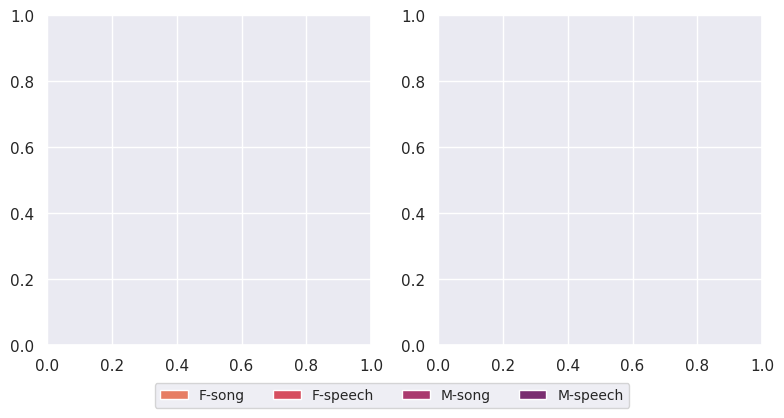

In [33]:
from matplotlib.patches import Patch
cmap= sns.color_palette("flare", 4)

fig, (ax2, ax1) = plt.subplots(1,2, figsize=(8,4))

classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.vocal_channel)], columns=["class"])
unique_classes = np.unique(classes)
map_classes = {c:i for c,i in zip(unique_classes, range(4))}
get_codes = lambda x: np.vectorize(map_classes.get)(x)
codes = get_codes(classes).reshape(-1)

legend_elements = [ Patch(facecolor=cmap[0], label=unique_classes[0]),
                     Patch(facecolor=cmap[1], label=unique_classes[1]),
                     Patch(facecolor=cmap[2], label=unique_classes[2]),
                     Patch(facecolor=cmap[3], label=unique_classes[3])]

fig.legend(handles=legend_elements, loc='center', fontsize=10, bbox_to_anchor=(0.5,-0.01), ncols=4);

In [34]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, n_init=3)
model = make_pipeline(PowerTransformer(), kmeans)
f1, f2 = greedy_optimizer(model, method="AMI")#["length_ms", "stft_min"] #greedy_optimizer(model, method="AMI")

X = quant[[f1, f2]]
labels = model.fit_predict(X)

dbd = DecisionBoundaryDisplay.from_estimator(model, X, response_method="predict", alpha=0.4, ax=ax1, palette="flare", grid_resolution=400)

sns.scatterplot(data=quant, x=f1, y=f2,s=5, hue=codes, palette=cmap,marker="s", ax=ax1, edgecolor=None, legend=False)
# sns.kdeplot(data=quant, x=f1, y=f2, ax=ax1, color="k", levels=[0.2, 0.5, 0.8], linewidths=0.5,alpha=0.8)

ax1.set_xlim(min(quant[f1]), max(quant[f1]))
ax1.set_ylim(min(quant[f2]), max(quant[f2]))
transf_centers = model.steps[0][1].inverse_transform(model.steps[1][1].cluster_centers_)
sns.scatterplot(x=transf_centers[:,0], y=transf_centers[:,1], marker="o",color="w",edgecolor="k",s=200, ax=ax1, legend=False)
for i, center in enumerate(transf_centers):
    ax1.text(center[0], center[1], str(i), va="center", ha="center", fontweight="bold")
plt.savefig("KMEANS-7clusters.pdf")

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


best AMI is for ['stft_min'] (S = 0.060762457411041734). Best match in category sex (0.2801027422766277), nlabels = 7
best AMI is for ['stft_min', 'kur'] (S = 0.08459272334313442). Best match in category sex (0.27000474935524776), nlabels = 7


/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:152: UserWarning: The following kwargs were not used by contour: 'palette'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


<Figure size 640x480 with 0 Axes>

In [35]:
kmeans = KMeans(n_clusters=2, n_init=3)
model = make_pipeline(PowerTransformer(), kmeans)
f1, f2 = greedy_optimizer(model, method="silhouette")

X = quant[[f1, f2]]
labels = model.fit_predict(X)

classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.vocal_channel)], columns=["class"])
dbd = DecisionBoundaryDisplay.from_estimator(model, X, response_method="predict", alpha=0.4, ax=ax2, palette="flare", grid_resolution=400)

sns.scatterplot(data=quant, x=f1, y=f2, s=5, hue=codes, marker="s",palette=cmap, ax=ax2, edgecolor=None, legend=False)

transf_centers = model.steps[0][1].inverse_transform(model.steps[1][1].cluster_centers_)
sns.scatterplot(x=transf_centers[:,0], y=transf_centers[:,1], marker="o",color="w",edgecolor="k",s=200, ax=ax2, legend=False)
# sns.kdeplot(data=quant, x=f1, y=f2, ax=ax2, color="k", levels=[0.2, 0.5, 0.8], linewidths=0.5, alpha=0.8)
for i, center in enumerate(transf_centers):
    ax2.text(center[0], center[1], str(i), va="center", ha="center", fontweight="bold")
    
ax2.set_xlim(min(quant[f1]), max(quant[f1]))
ax2.set_ylim(min(quant[f2]), max(quant[f2]))

best silhouette is for ['sc_max'] (S = 0.6498028778375644). Best match in category sex (0.027598834122416163), nlabels = 2
best silhouette is for ['sc_max', 'mfcc_max'] (S = 0.5097277005765569). Best match in category sex (0.11781630625722574), nlabels = 2


/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:152: UserWarning: The following kwargs were not used by contour: 'palette'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


(126.25081, 280.1737)

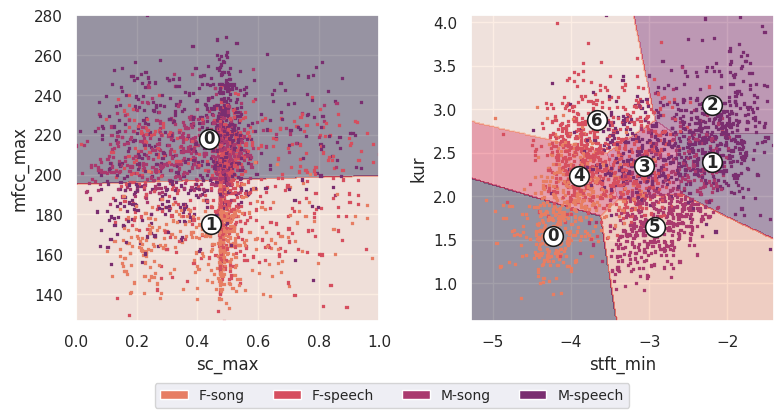

In [36]:
fig.tight_layout()
fig.savefig("kmeans_cluster_2_7.pdf", bbox_inches='tight')
display(fig)

DBSCAN

In [159]:
from sklearn.cluster import DBSCAN
transformer = QuantileTransformer(output_distribution='normal')
dbscan_df = pd.DataFrame(columns=["eps", "f1", "f2", "score", "nlabels"])
for eps in np.linspace(0.01,0.4,20 ):
    print(f"eps = {eps}-------------")
    dbscan = DBSCAN(eps=eps, min_samples=5)
    model = make_pipeline(transformer, dbscan)
    f1, f2, score, nlabels = greedy_optimizer(model, method="sil_over_noise")
    dbscan_df = pd.concat([dbscan_df, pd.DataFrame({"eps":eps, "f1":f1, "f2":f2, "score":score, "nlabels":nlabels}, index=[0])], ignore_index=True)
    print("----------------------------")

eps = 0.01-------------
best sil_over_noise is for ['length_ms'] (S = 0.02631578947368421). Best match in category vocal_channel (0.1816719259580206), nlabels = 73
best sil_over_noise is for ['length_ms', 'stft_mean'] (S = 0.0004137332251659146). Best match in category vocal_channel (0.004863508717590241), nlabels = 3
----------------------------
eps = 0.030526315789473686-------------
best sil_over_noise is for ['length_ms'] (S = 0.03117038005593824). Best match in category vocal_channel (0.18145887576271802), nlabels = 74
best sil_over_noise is for ['length_ms', 'stft_kur'] (S = 0.00042284912130785763). Best match in category vocal_channel (0.0316316867706983), nlabels = 18
----------------------------
eps = 0.05105263157894737-------------
best sil_over_noise is for ['length_ms'] (S = 0.03369357748496255). Best match in category vocal_channel (0.20708333667178763), nlabels = 39
best sil_over_noise is for ['length_ms', 'sc_std'] (S = 0.0002985611379890232). Best match in category voc

eps        0.338421
f1              kur
f2         mfcc_std
score      0.016898
nlabels           3
Name: 16, dtype: object
         eps         f1         f2     score nlabels
6   0.133158  length_ms     sc_min -0.001021      18
4   0.092105   stft_std       mean -0.000730      51
7   0.153684     sc_kur  mfcc_mean -0.000615       4
8   0.174211  length_ms     sc_std -0.000462       7
5   0.112632   stft_kur  stft_mean -0.000272      15
9   0.194737  length_ms    sc_skew -0.000194       4
3   0.071579     sc_std  length_ms -0.000051      77
2   0.051053  length_ms     sc_std  0.000299      75
0   0.010000  length_ms  stft_mean  0.000414       3
1   0.030526  length_ms   stft_kur  0.000423      18
10  0.215263  length_ms     sc_max  0.002113       3
11  0.235789  length_ms     sc_min  0.004997       3
12  0.256316  length_ms    sc_skew  0.008282       3
13  0.276842        kur  mfcc_mean  0.009015       3
14  0.297368        kur  mfcc_mean  0.010503       3
17  0.358947        kur     

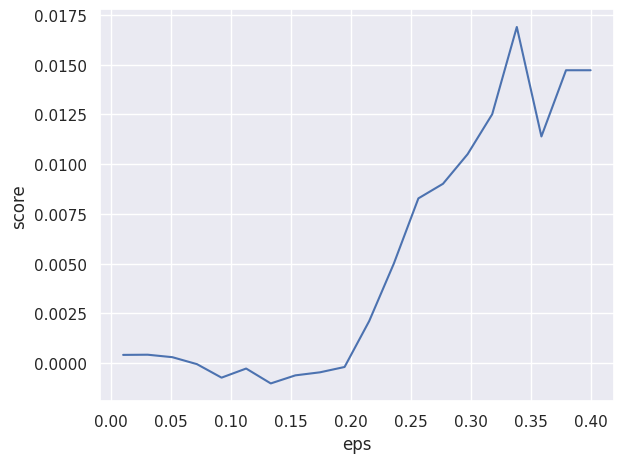

In [160]:
sns.lineplot(data=dbscan_df, x="eps", y="score")
bastard = np.argmax(dbscan_df.score)
print(dbscan_df.loc[bastard])
print(dbscan_df.sort_values(by="score"))

[-1  0  1]
[-1  0  1]


<AxesSubplot: xlabel='sc_max', ylabel='length_ms'>

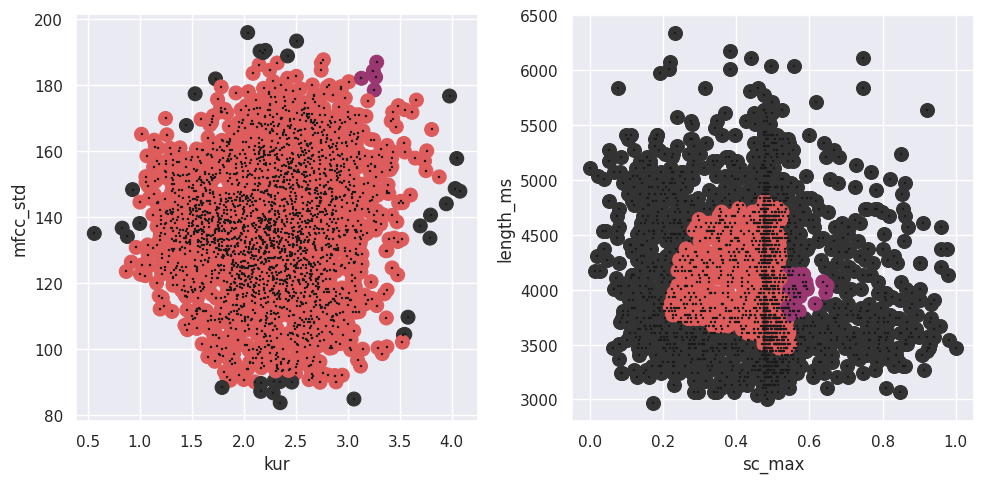

In [166]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5));

dbscan = DBSCAN(eps=0.33, min_samples=5)
model = make_pipeline(transformer, dbscan)
f1, f2 = "kur", "mfcc_std" # greedy_optimizer(model, method="silhouette")

X = quant[[f1, f2]]
model.fit(X)
labels = model.steps[1][1].labels_
print(np.unique(labels))
classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.emotion)], columns=["class"])
colors = [[0.2,0.2,0.2]] + sns.color_palette("flare", len(np.unique(labels))-1)

sns.scatterplot(data=quant, x=f1, y=f2, s= 100, hue=labels, marker="o", alpha=1, palette=colors, edgecolor=None, legend=False, ax=ax1)
sns.scatterplot(data=quant, x=f1, y=f2, s=4, color="k", alpha=1, marker="s", edgecolor=None, legend=False, ax=ax1)

############################

dbscan = DBSCAN(eps=0.15, min_samples=20)
model = make_pipeline(transformer, dbscan)
f1, f2 = "sc_max", "length_ms" # greedy_optimizer(model, method="silhouette")

X = quant[[f1, f2]]
model.fit(X)
labels = model.steps[1][1].labels_
print(np.unique(labels))
classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.emotion)], columns=["class"])
colors =  sns.color_palette("flare", len(np.unique(labels))-1)

loc_out = (labels==-1)
loc_ok = (labels!=-1)

sns.scatterplot(data=quant[loc_out], x=f1, y=f2, s= 100, marker="o", alpha=1, color=([0.2,0.2, 0.2]) , edgecolor=None, legend=False, ax=ax2)
sns.scatterplot(data=quant[loc_ok], x=f1, y=f2, s= 100, hue=labels[loc_ok], marker="o", alpha=1, palette=colors, edgecolor=None, legend=False, ax=ax2)
sns.scatterplot(data=quant, x=f1, y=f2, s=4, color="k", alpha=1, marker="s", edgecolor=None, legend=False, ax=ax2)


# ax.set_xlim(min(quant[f1])*(1-0.15), max(quant[f1])*(1+0.15))
# ax.set_ylim(min(quant[f2])*(1+0.15), max(quant[f2])*(1+0.15))